In [2]:
renv::load(here::here())

In [3]:
library(sicegar)
library(dplyr)
library(tibble)
library(tidyr)
library(readr)
library(stringr)
library(purrr)
library(here)
library(lubridate)
library(magrittr)
library(ggplot2)
library(scales)
library(ggpubr)
renv::install("animation")
library(animation)
# renv::install("AeRobiology")
# library(AeRobiology)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


here() starts at /users/sadamov/RProjects/CHAPo


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




Installing animation [2.6] ...
	OK [linked cache]


# Data Import and Preparation

We are working with 21 years of data 2000-2020, 14 stations and 3 species leading to a total of 882 data sets.

In [4]:
pollen_daily <- read_delim(paste0(here(), "/data/dwh/pollen_dwh_daily.txt"), delim = " ", skip = 17, trim_ws = TRUE)
pollen_daily %<>%
    mutate(across(where(is.numeric), ~ if_else(. < 0, NA_real_, .)),
        datetime = ymd_hm(paste0(YYYY, "-", sprintf("%02d", MM), "-", sprintf("%02d", DD), " ", sprintf("%02d", HH), ":", sprintf("%02d", mm))),
        year = year(datetime)
    ) %>%
    filter(year <= 2020) %>%
    select(-(YYYY:mm)) %>%
    setNames(tolower(names(.))) %>%
    pivot_longer(plo:pcf, names_to = "station", values_to = "conc")

pollen_split <- pollen_daily %>%
    # split(list(.$year, .$station, .$parameter))
    split(.$parameter) %>%
    map(~ .x %>% split(list(.$year, .$station)))

# larger_ten <- function(x) x > 0
# season_start <- map(pollen_split, ~detect_index(replace(.x$conc, is.na(.x$conc), 0), larger_ten))
# season_end <- map(pollen_split, ~detect_index(replace(.x$conc, is.na(.x$conc), 0), larger_ten, .dir = "backward"))


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [5]:
# season_def_alnu <- map(pollen_split[["ALNU24"]], ~ .x %>%
#   select(datetime, conc) %>%
#   calculate_ps(
#     method = "clinical",
#     n.clinical = 5,
#     window.clinical = 7,
#     th.pollen = 10,
#     th.sum = 100,
#     plot = FALSE,
#     result = "table"
#   ))

# season_def_betu <- map(pollen_split[["BETU24"]], ~ .x %>%
#   select(datetime, conc) %>%
#   calculate_ps(
#     method = "clinical",
#     n.clinical = 5,
#     window.clinical = 7,
#     th.pollen = 10,
#     th.sum = 100,
#     plot = FALSE,
#     result = "table"
#   ))

# season_def_poac <- map(pollen_split[["POAC24"]], ~ .x %>%
#   select(datetime, conc) %>%
#   calculate_ps(
#     method = "clinical",
#     n.clinical = 5,
#     window.clinical = 7,
#     th.pollen = 3,
#     th.sum = 30,
#     plot = FALSE,
#     result = "table"
#   ))

# season_def = c(season_def_alnu, season_def_betu, season_def_poac)
# save(season_def, file = paste0(here(), "/data/other/season_def.Rdata"))

# season_start <- map(season_def, ~ .x$st.jd) %>% unlist
# season_end <- map(season_def, ~ .x$en.jd) %>% unlist

# pollen_clean <- unlist(pollen_split, recursive = FALSE)
# pollen_clean <- pollen_clean[-which(is.na(season_start))]
# season_start <- season_start[!is.na(season_start)]
# season_end <- season_end[!is.na(season_end)]

In [6]:
load(paste0(here(), "/data/other/season_def.Rdata"))
season_start <- map(season_def, ~ .x$st.jd) %>% unlist()
season_end <- map(season_def, ~ .x$en.jd) %>% unlist()

pollen_clean <- unlist(pollen_split, recursive = FALSE)
pollen_clean <- pollen_clean[-which(is.na(season_start))]
season_start <- season_start[!is.na(season_start)]
season_end <- season_end[!is.na(season_end)]

Warning message:
“ 252 failed to parse.”
Warning message:
“Removed 28701 rows containing missing values (position_stack).”
Warning message:
“Removed 28696 rows containing missing values (position_stack).”


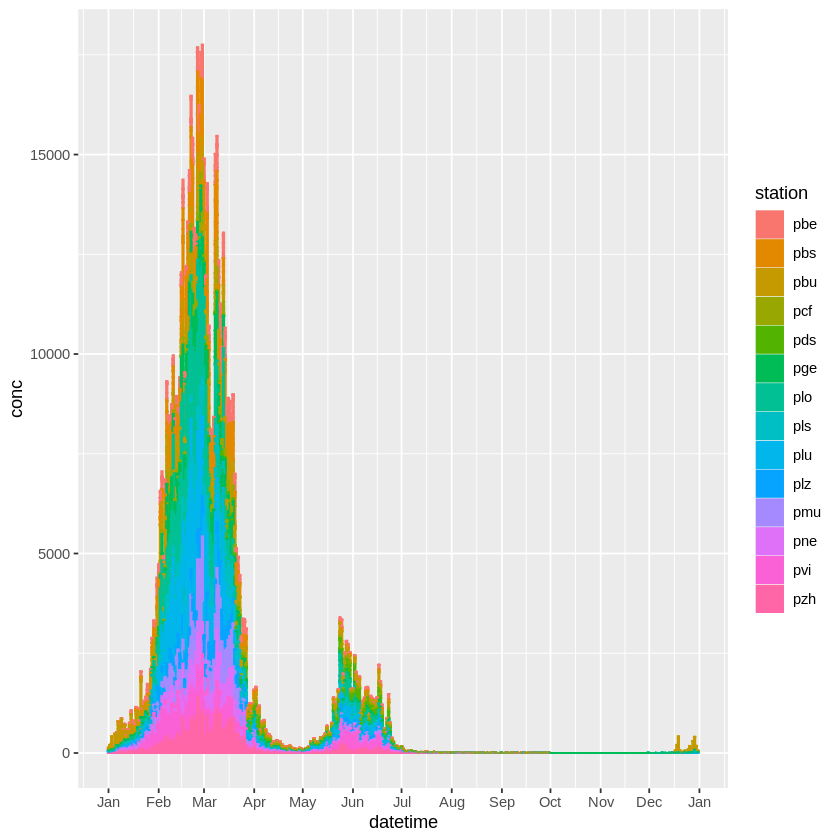

Warning message:
“Removed 28684 rows containing missing values (position_stack).”


$ALNU24

$BETU24

$POAC24


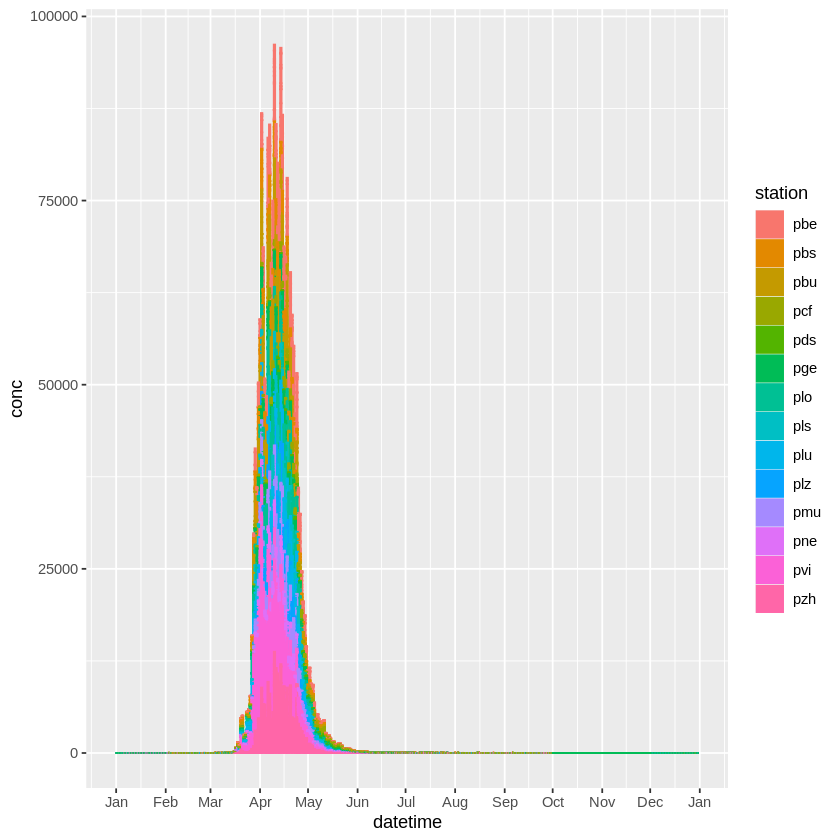

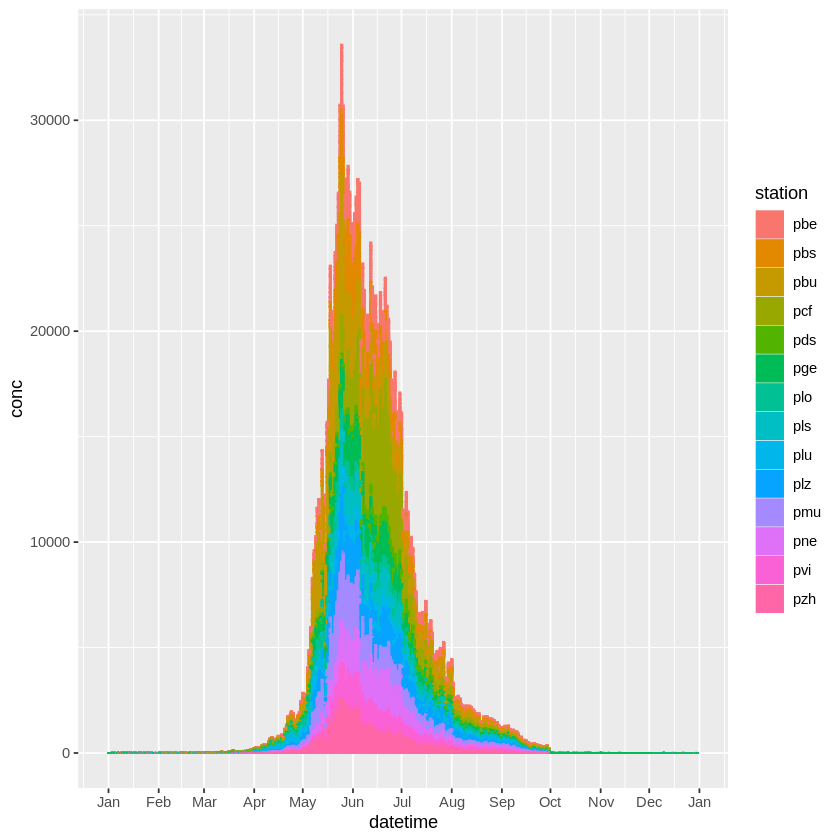

In [7]:
pollen_monthday <- pollen_daily %>%
  mutate(
    monthday = paste0(sprintf("%02d", month(datetime)), sprintf("%02d", day(datetime))),
    datetime = ymd(paste0("2001", monthday))
  ) %>%
  # filter(monthday != "0229") %>%
  split(.$parameter)

map(pollen_monthday, ~ .x %>%
  ggplot(aes(x = datetime, y = conc)) +
  geom_col(aes(fill = station, col = station)) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month"))

In [8]:

pollen_window <- pmap(list(pollen_clean, season_start, season_end), ~
..1 %>%
  slice(..2:..3) %>%
  mutate(length = ..2) %>%
  rowid_to_column("day"))

pollen_join <- pollen_window %>% bind_rows()

In [9]:
pollen_median_species <- pollen_join %>%
  group_by(day, parameter, station) %>%
  summarise(conc = sum(conc, na.rm = TRUE)) %>%
  ungroup() %>%
  split(.$parameter)

`summarise()` has grouped output by 'day', 'parameter'. You can override using the `.groups` argument.



In [10]:
alnus_season <- pollen_median_species[["ALNU24"]]  %>%
  filter(day < 80)
# %>% mutate(conc = if_else(day > 75, 0, conc))

add_days_alnus <- tibble(
  day = rep(0, 14),
  parameter = "ALNU24",
  station = unique(alnus_season$station),
  conc = 0
)

alnus_season <- add_days_alnus %>%
  bind_rows(alnus_season)

betula_season <- pollen_median_species[["BETU24"]] 
# %>% mutate(conc = if_else(day > 60, 0, conc))

add_days_betula <- tibble(
  day = rep(0, 14),
  parameter = "BETU24",
  station = unique(betula_season$station),
  conc = 0
)

betula_season <- add_days_betula %>%
  bind_rows(betula_season)

poaceae_season <- pollen_median_species[["POAC24"]] 
# %>% mutate(conc = if_else(day > 180, 0, conc))

add_days_poaceae <- tibble(
  day = rep(0, 14),
  parameter = "POAC24",
  station = unique(poaceae_season$station),
  conc = 0
)

poaceae_season <- add_days_poaceae %>%
  bind_rows(poaceae_season)

pollen_season <- list(
  ALNU24 = alnus_season,
  BETU24 = betula_season,
  POAC24 = poaceae_season
)

## Timeseries 

this too

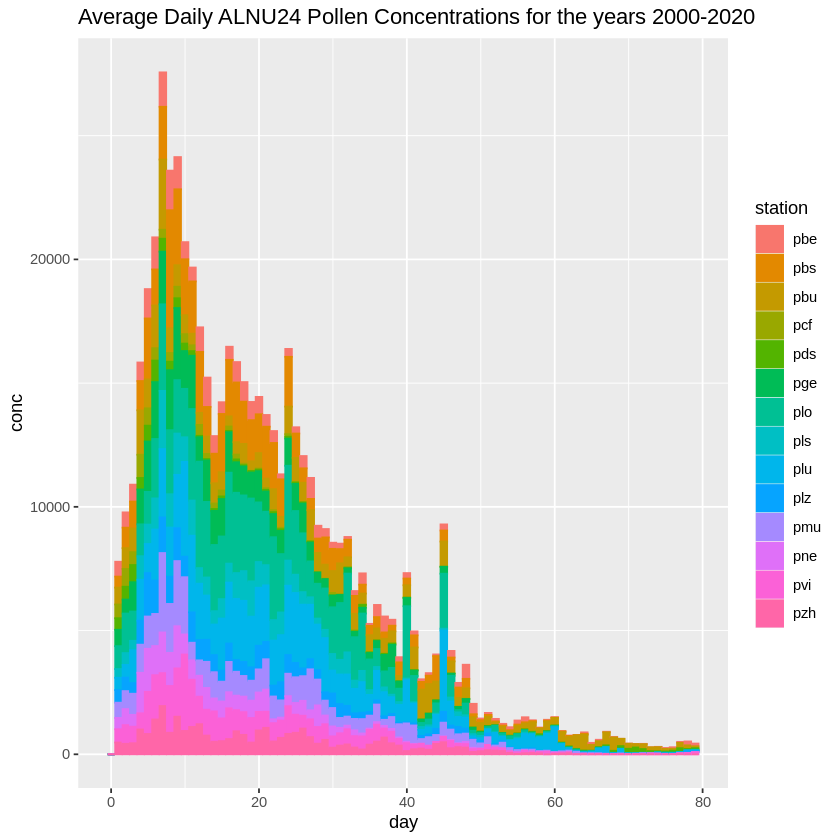

$ALNU24

$BETU24

$POAC24


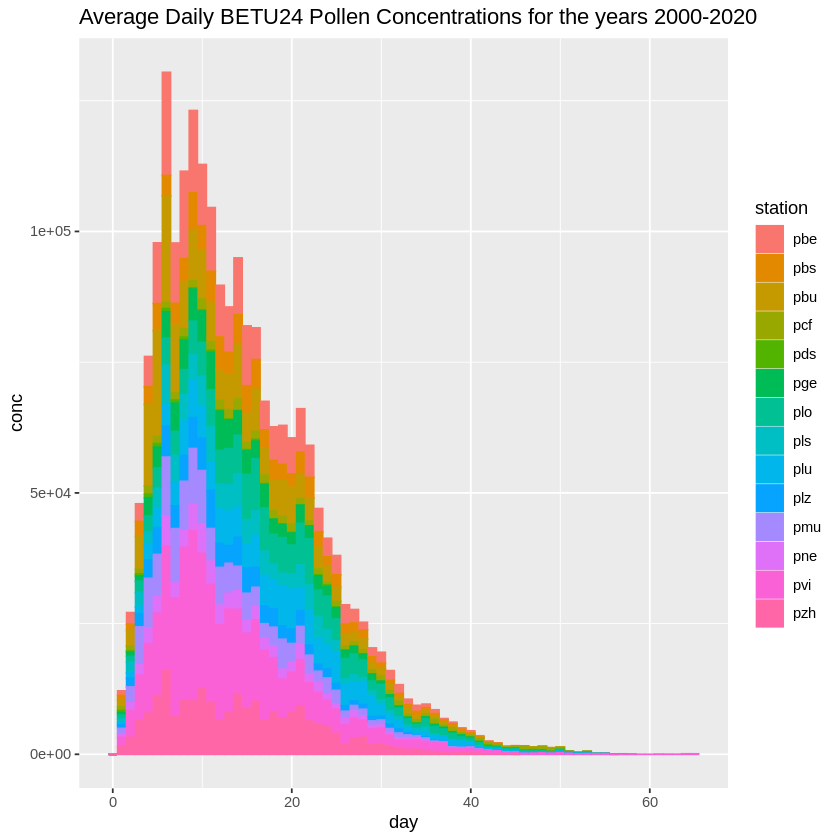

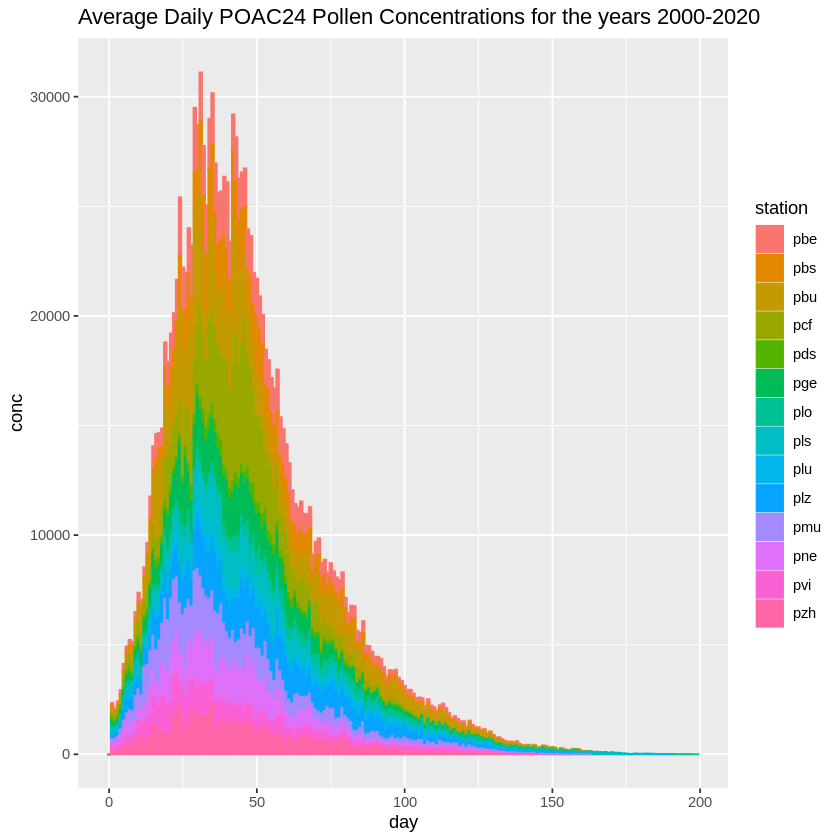

In [11]:
map(pollen_season, ~ .x %>%
ggplot(aes(x = day, y = conc, col = station, fill = station)) +
    geom_col() +
    # xlim(c(0, 5)) +
    ggtitle(paste("Average Daily", unique(.x$parameter), "Pollen Concentrations for the years 2000-2020")))

Rescaling here is necessary because of the way slope1 and slope2 are calculated numerically in the sicegar package. Maybe we should contact the authors, as I am not certain that they wanted the slopes to depend on the scale of the values in the timeseries.

In [12]:
pollen_sum_day <- map(pollen_season, ~ .x %>%
  group_by(day, parameter) %>%
  summarise(conc = median(conc, na.rm = TRUE)) %>%
  ungroup() %>%
  # mutate(conc = case_when(parameter == "ALNU24" ~ rescale(conc, to = c(0, 1.48)),
  #                         parameter == "BETU24" ~ rescale(conc, to = c(0, 1.13)),
  #                         parameter == "POAC24" ~ rescale(conc, to = c(0, 1.14)))) %>%
  select(time = day, intensity = conc))


`summarise()` has grouped output by 'day'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'day'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'day'. You can override using the `.groups` argument.



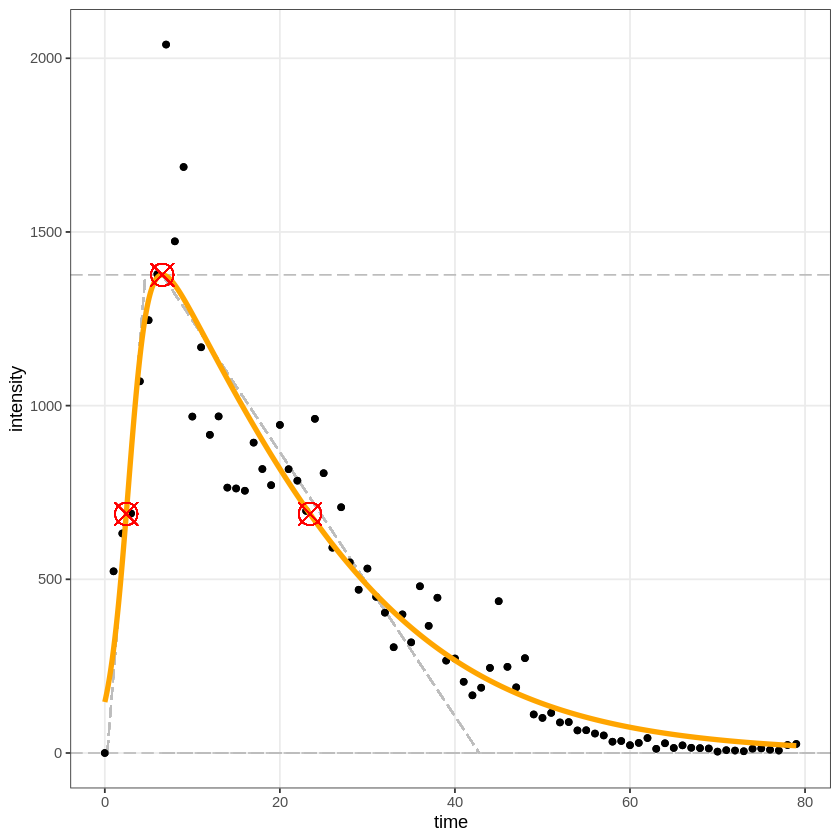

$ALNU24
$ALNU24[[1]]

$ALNU24[[2]]
# A tibble: 71 x 2
   name                                    value               
   <chr>                                   <chr>               
 1 finalAsymptoteIntensityRatio_N_Estimate 0                   
 2 finalAsymptoteIntensityRatio_Std_Error  0.0410251544489457  
 3 finalAsymptoteIntensityRatio_t_value    0                   
 4 finalAsymptoteIntensityRatio_Pr_t       1                   
 5 maximum_N_Estimate                      0.674909463962932   
 6 maximum_Std_Error                       0.0297091459710125  
 7 maximum_t_value                         22.7172287154079    
 8 maximum_Pr_t                            4.28759711612439e-35
 9 slope1Param_N_Estimate                  66.8324158225301    
10 slope1Param_Std_Error                   15.3548742161708    
# … with 61 more rows


$BETU24
$BETU24[[1]]

$BETU24[[2]]
# A tibble: 70 x 2
   name                                    value               
   <chr>                            

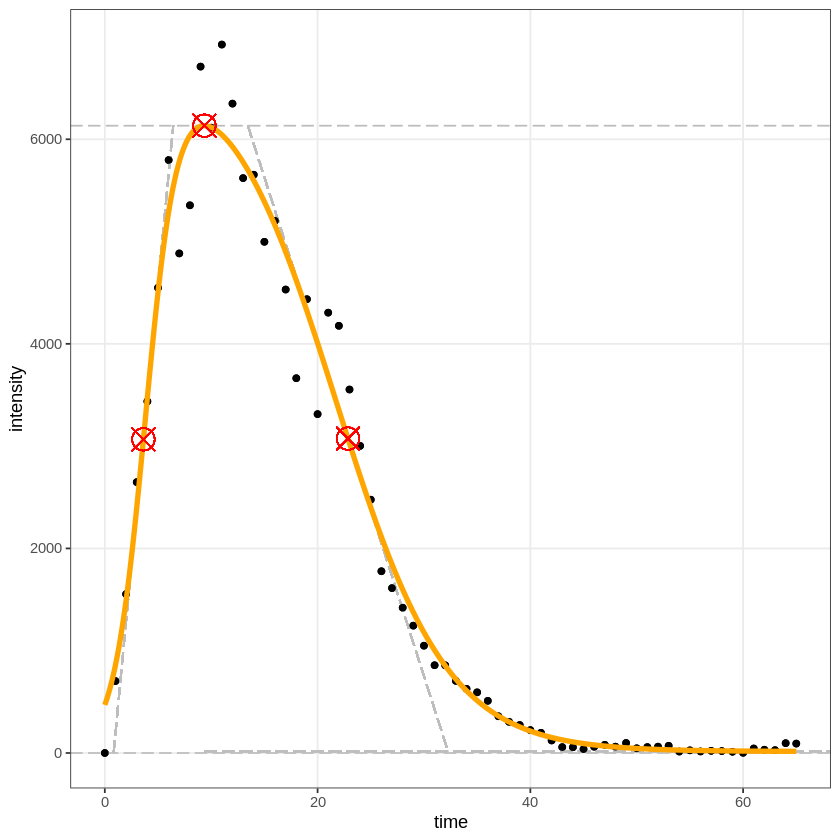

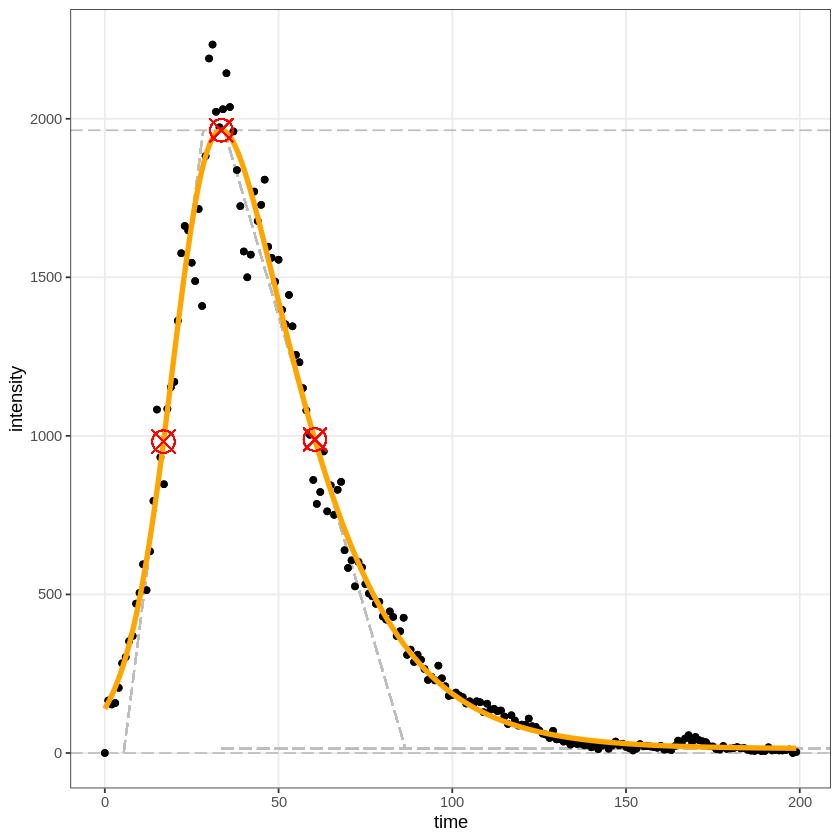

In [13]:
fit_curve <- function(x) {
  normalizedInput <- normalizeData(
    dataInput = x,
    dataInputName = "doubleSigmoidalSample"
  )
  # Fit double-sigmoidal model
  doubleSigmoidalModel <- multipleFitFunction(
    dataInput = normalizedInput,
    model = "doublesigmoidal",
    n_runs_min = 100,
    n_runs_max = 500,
    showDetails = FALSE
  )
  # Calculate additional parameters
  doubleSigmoidalParams <- parameterCalculation(doubleSigmoidalModel)

  # Plotting the model
  plot <- figureModelCurves(
    dataInput = normalizedInput,
    doubleSigmoidalFitVector = doubleSigmoidalParams,
    showParameterRelatedLines = TRUE
  )

  # Table with parameters
  params <- doubleSigmoidalParams %>%
    mutate(across(everything(), as.character)) %>%
    pivot_longer(everything())

  return(list(plot, params))
}
fitted_curves <- map(pollen_sum_day, ~ fit_curve(.x))

fitted_curves


## Comparison with the curves currently used in COSMO
The first factor is a scaling factor
The second factor describes the ascending slope
The third factor describes the descendig slope


For the double-sigmoidal model, key parameters describing the curve are:

    maximum: The maximum intensity the double-sigmoidal curve reaches.
    final asymptotic intensity: The intensity the curve decreases to after having reached its maximum.
    midpoint 1: The time point at which the double-sigmoidal curve reaches half of its maximum intensity during the initial rise.
    slope 1: The slope at midpoint 1.
    midpoint 2: The time point at which the double-sigmoidal curve reaches the intensity corresponding to the mean of the maximum intensity and the final asymptotic intensity.
    slope 2: The slope at midpoint 2.

https://cran.r-project.org/web/packages/sicegar/vignettes/introduction.html

In [16]:
# ALNUS

params_alnus <- fitted_curves[["ALNU24"]][[2]]

max_length <- params_alnus %>%
  filter(name == "endDeclinePoint_x") %>%
  pull(value) %>%
  as.numeric()
maximum <- params_alnus %>%
  filter(name == "maximum_y") %>%
  pull(value) %>%
  as.numeric()
midpoint1 <- params_alnus %>%
  filter(name == "midPoint1_x") %>%
  pull(value) %>%
  as.numeric()
slope1 <- params_alnus %>%
  filter(name == "slope1") %>%
  pull(value) %>%
  as.numeric() * 4 / maximum
midpoint2 <- params_alnus %>%
  filter(name == "midPoint2_x") %>%
  pull(value) %>%
  as.numeric()
slope2 <- params_alnus %>%
  filter(name == "slope2") %>%
  pull(value) %>%
  as.numeric() * -4 / maximum

gg_alnus <- list()
tb_alnus <- list()
x <- 0:100
i <- 1

for (saisl in seq(5, 60, 5)) {
  slope1_adj <- (slope1 - 0.65) * max_length / saisl
  slope2_adj <- (slope2 + 0.11) * max_length / saisl
  midpoint1_adj <- (midpoint1 + 17) * saisl / max_length
  midpoint2_adj <- midpoint2 * saisl / max_length
  maximum_adj <- 1.61

  y_new_fit <- ((maximum_adj) / (1 + exp((-slope1_adj) * (x - midpoint1_adj)))) *
    ((maximum_adj) / (1 + exp((slope2_adj) * (x - midpoint2_adj))))

  y_cosmo <- (exp(-0.152 * saisl + 6) + 1) * (1 / (1 + exp(-x * 0.3 + 7))) *
    (1 / (1 + exp(17 / saisl * x - 12)) - 0.005)

  data_curves <- tibble(x, y = y_cosmo, col = "Old Fit") %>%
    bind_rows(tibble(x, y = y_new_fit, col = "New Fit"))

  gg_alnus[[i]] <- data_curves %>%
    ggplot() + 
    geom_line(aes(x = x, y = y, col = col)) +
    scale_x_continuous(limits = c(0, 100)) +
    scale_y_continuous(limits = c(-0.1, 1.2)) +
    theme_minimal() +
    theme(text = element_text(size = 20)) +
    labs(x = "Day in Season", y = "Season Description (SDES)", col = "") +
    ggtitle(paste("Alnus - Season Length:", saisl))

  tb_alnus[[i]] <- tibble(
    name = c("max_length", "slope1", "midpoint1", "slope2", "midpoint2"),
    orig = c(max_length, slope1, midpoint1, slope2, midpoint2),
    adj = c(max_length, slope1_adj, midpoint1_adj, slope2_adj, midpoint2_adj)
  )
  i <- i + 1
}
tb_alnus[[1]]

saveGIF(
  {
    for (i in seq_along(gg_alnus)) {
      print(gg_alnus[[i]])
    }
  },
  movie.name = paste0(here(), "/vignettes/figures/sdes_alnus.gif"),
  interval = 0.5,
  ani.width = 1600,
  ani.height = 900
)


name,orig,adj
<chr>,<dbl>,<dbl>
max_length,42.7813860,42.781386
slope1,0.9213225,2.321511
midpoint1,2.4505509,2.273249
slope2,0.1033978,1.825891
midpoint2,23.4386200,2.739348


Warning message:
“Removed 84 row(s) containing missing values (geom_path).”
Warning message:
“Removed 81 row(s) containing missing values (geom_path).”
Warning message:
“Removed 78 row(s) containing missing values (geom_path).”
Warning message:
“Removed 63 row(s) containing missing values (geom_path).”
Output at: /users/sadamov/RProjects/CHAPo/vignettes/figures/sdes_alnus.gif



[1] FALSE

In [ ]:
# BETULA

params_betula <- fitted_curves[["BETU24"]][[2]]
max_length <- params_betula %>%
  filter(name == "endDeclinePoint_x") %>%
  pull(value) %>%
  as.numeric()
maximum <- params_betula %>%
  filter(name == "maximum_y") %>%
  pull(value) %>%
  as.numeric()
midpoint1 <- params_betula %>%
  filter(name == "midPoint1_x") %>%
  pull(value) %>%
  as.numeric()
slope1 <- params_betula %>%
  filter(name == "slope1") %>%
  pull(value) %>%
  as.numeric() * 4 / maximum
midpoint2 <- params_betula %>%
  filter(name == "midPoint2_x") %>%
  pull(value) %>%
  as.numeric()
slope2 <- params_betula %>%
  filter(name == "slope2") %>%
  pull(value) %>%
  as.numeric() * -4 / maximum

gg_betula <- list()
tb_betula <- list()
x <- 0:100
i <- 1

for (saisl in seq(5, 60, 5)) {

  y_cosmo <- 2 * (1 / (1 + exp(-x * 0.5)) - 0.5) * exp(-((0.08 * x - 0.8) *
    (0.08 * x - 0.8))) * (1 / (1 + exp((log(39) + 8) / saisl * x - 8)) - 0.025)

  midpoint1_adj <- (midpoint1 + 2) * saisl / max_length
  midpoint2_adj <- midpoint2 * saisl / max_length
  slope1_adj <- (slope1 + 0.15) * max_length / saisl
  slope2_adj <- (slope2 + 0.18) * max_length / saisl
  maximum_adj <- 1.01
  # level_adj <- level

  y_new_fit_betu <- ((maximum_adj) / (1 + exp((-slope1_adj) * (x - midpoint1_adj)))) *
    ((maximum_adj) / (1 + exp((slope2_adj) * (x - midpoint2_adj))))

  data_curves <- tibble(x, y = y_cosmo, col = "Old Fit") %>%
    bind_rows(tibble(x, y = y_new_fit_betu, col = "New Fit"))

  gg_betula[[i]] <- data_curves %>%
    ggplot() + 
    geom_line(aes(x = x, y = y, col = col)) +
    scale_x_continuous(limits = c(0, 100)) +
    scale_y_continuous(limits = c(-0.1, 1.2)) +
    theme_minimal() +
    theme(text = element_text(size = 20)) +
    labs(x = "Day in Season", y = "Season Description (SDES)", col = "") +
    ggtitle(paste("Betula - Season Length:", saisl))

  tb_betula[[i]] <- tibble(
    name = c("max_length", "slope1", "midpoint1", "slope2", "midpoint2"),
    orig = c(max_length, slope1, midpoint1, slope2, midpoint2),
    adj = c(max_length, slope1_adj, midpoint1_adj, slope2_adj, midpoint2_adj)
  )

  i <- i + 1
}

tb_betula[[1]]

saveGIF(
  {
    for (i in seq_along(gg_betula)) {
      print(gg_betula[[i]])
    }
  },
  movie.name = paste0(here(), "/vignettes/figures/sdes_betula.gif"),
  interval = 0.5,
  ani.width = 1600,
  ani.height = 900
)

In [18]:
# POACEAE

params_poaceae <- fitted_curves[["POAC24"]][[2]]
max_length <- params_poaceae %>%
  filter(name == "endDeclinePoint_x") %>%
  pull(value) %>%
  as.numeric()
maximum <- params_poaceae %>%
  filter(name == "maximum_y") %>%
  pull(value) %>%
  as.numeric()
midpoint1 <- params_poaceae %>%
  filter(name == "midPoint1_x") %>%
  pull(value) %>%
  as.numeric()
slope1 <- params_poaceae %>%
  filter(name == "slope1") %>%
  pull(value) %>%
  as.numeric() * 4 / maximum
midpoint2 <- params_poaceae %>%
  filter(name == "midPoint2_x") %>%
  pull(value) %>%
  as.numeric()
slope2 <- params_poaceae %>%
  filter(name == "slope2") %>%
  pull(value) %>%
  as.numeric() * -4 / maximum


gg_poaceae <- list()
tb_poaceae <- list()
x <- 1:250
i <- 1

for (saisl in seq(10, 150, 5)) {
  y_cosmo <- 1.03 * (1 / (1 + exp(-0.3 * x + 3.5)) - 0.03) *
    (1 / (1 + exp((log(499) + 8) / saisl * x - 7)) - 0.001)

  midpoint1_adj <- midpoint1 * saisl / max_length
  midpoint2_adj <- midpoint2 * saisl / max_length
  slope1_adj <- (slope1 + 0.1) * max_length / saisl
  slope2_adj <- (slope2 + 0.08) * max_length / saisl
  maximum_adj <- 1.01
  # level_adj <- level + 0.02

  y_new_fit <- ((maximum_adj) / (1 + exp((-slope1_adj) * (x - midpoint1_adj)))) *
    ((maximum_adj) / (1 + exp((slope2_adj) * (x - midpoint2_adj))))

  data_curves <- tibble(x, y = y_cosmo, col = "Old Fit") %>%
    bind_rows(tibble(x, y = y_new_fit, col = "New Fit"))

  gg_poaceae[[i]] <- data_curves %>%
    ggplot() + 
    geom_line(aes(x = x, y = y, col = col)) +
    scale_x_continuous(limits = c(0, 160)) +
    scale_y_continuous(limits = c(-0.1, 1.2)) +
    theme_minimal() +
    theme(text = element_text(size = 20)) +
    labs(x = "Day in Season", y = "Season Description (SDES)", col = "") +
    ggtitle(paste("Poaceae - Season Length:", saisl))

  tb_poaceae[[i]] <- tibble(
    name = c("max_length", "slope1", "midpoint1", "slope2", "midpoint2"),
    orig = c(max_length, slope1, midpoint1, slope2, midpoint2),
    adj = c(max_length, slope1_adj, midpoint1_adj, slope2_adj, midpoint2_adj)
  )

  i <- i + 1
}

tb_poaceae[[1]]

saveGIF(
  {
    for (i in seq_along(gg_poaceae)) {
      print(gg_poaceae[[i]])
    }
  },
  movie.name = paste0(here(), "/vignettes/figures/sdes_poaceae.gif"),
  interval = 0.5,
  ani.width = 1600,
  ani.height = 900
)

name,orig,adj
<chr>,<dbl>,<dbl>
max_length,86.53823000,86.538230
slope1,0.17473129,2.377476
midpoint1,16.87772000,1.950320
slope2,0.07610791,1.350930
midpoint2,60.43972801,6.984165


Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 row(s) containing missing values (geom_path).”

In [ ]:
# data_curves_betu_scaled <-
#   data_curves_betu %>%
#   mutate(y = y * 700) %>%
#   filter(col == "New Fit")

# pollen_mean_species[[2]] %>%
#   ggplot() +
#     geom_col(aes(x = day, y = conc, col = station, fill = station)) +
#     geom_line(data = data_curves_betu_scaled, aes(x = x, y = y), col = "#f4b258", size = 1) +
#     theme_minimal() +
#     theme(legend.position = "none") +
#     scale_fill_manual(values = rep(rev(c("#206f60", "#428d7d", "#61ac9b", "#80ccba", "#a0edda")), each = 3)) +
#     scale_color_manual(values = rep(rev(c("#206f60", "#428d7d", "#61ac9b", "#80ccba", "#669b8e")), each = 3)) +
#     scale_x_continuous(limits = c(0, 70)) +
#     scale_y_continuous(limits = c(0, 750)) +
#     xlab("Day in the Pollen-Season") +
#     ylab("Daily Birch Concentration [m^-3]") +
#     ggtitle("Average Daily Birch Pollen Concentrations for 2000-2020 Stacked for All Stations")

#     ggsave(paste0(here(), "/vignettes/figures/gg_presentation.png"), width = 24, height = 13.5, dpi = 300, units = c("cm"))

# pollen_mean_species[[2]] %>%
#   ggplot() +
#     # geom_col(aes(x = day, y = conc, col = station, fill = station)) +
#     geom_line(data = data_curves_betu_scaled, aes(x = x, y = y), col = "#f4b258", size = 1) +
#     theme_minimal() +
#     theme(legend.position = "none") +
#     scale_fill_manual(values = rep(rev(c("#206f60", "#428d7d", "#61ac9b", "#80ccba", "#a0edda")), each = 3)) +
#     scale_color_manual(values = rep(rev(c("#206f60", "#428d7d", "#61ac9b", "#80ccba", "#a0edda")), each = 3)) +
#     scale_x_continuous(limits = c(0, 70)) +
#     scale_y_continuous(limits = c(0, 750)) +
#     xlab("Day in the Pollen-Season") +
#     ylab("Daily Birch Concentration [m^-3]") +
#     ggtitle("Average Daily Birch Pollen Concentrations for 2000-2020 Stacked for All Stations")

#     ggsave(paste0(here(), "/vignettes/figures/gg_presentation_empty_10.png"), width = 24, height = 13.5, dpi = 300, units = c("cm"))